Importação do csv

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import lightgbm as lgb
import pickle

df = pd.read_csv("../../../../Files/df_to_train.csv")
df['Total_Review'] = df['Total_Review'].fillna('')
df.head(5)


,Total_Review,review_type
0,Location excellent rooms extremely comfortable...,positive
1,comfortable bed excellent air con great locati...,positive
2,views,positive
3,Clean comfortable room Kettle selection tea ba...,positive
4,Beds comfy staff lovely food amazing room spac...,positive


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

def remove_specific_words(text):
    stop_words = set(stopwords.words('english')) 
    domain_specific_stop_words = {'hotel', 'Hotel', 'room', 'bathroom'} 
    all_stop_words = stop_words.union(domain_specific_stop_words)
    
    stemmer = PorterStemmer(PorterStemmer.ORIGINAL_ALGORITHM)
  
    tokens = word_tokenize(text)
    splitted_words_without_stops = [word for word in tokens if not word in all_stop_words]
    splitted_words_without_puncs = [word for word in splitted_words_without_stops if word.isalnum()] 
    stemmed_words = [stemmer.stem(word) for word in splitted_words_without_puncs]

    return ' '.join(stemmed_words)

In [3]:
df['Clean_Review'] = df['Total_Review'].apply(remove_specific_words)

Criar objeto TF-IDF Vectorizer

In [4]:
tfidf_vect = TfidfVectorizer(max_features=7000, ngram_range=(1, 3))
tfidf_vect.fit(df.Clean_Review)

with open('tfidf_vectorizer_lgb.pkl', 'wb') as f:
    pickle.dump(tfidf_vect, f)

text_vect = tfidf_vect.transform(df.Clean_Review)

Mapear os valores para numéricos e dividir os dados em conjunto de treinamento e teste

In [5]:
X = text_vect
y = df['review_type']
y = y.map({'positive': 2, 'neutral': 1, 'negative': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Instanciar Modelo LightGBM

In [6]:
lgbm = lgb.LGBMClassifier(n_estimators=1000,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

Treino

In [7]:
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135323
[LightGBM] [Info] Number of data points in the train set: 25747, number of used features: 3736
[LightGBM] [Info] Start training from score -1.094697
[LightGBM] [Info] Start training from score -1.099934
[LightGBM] [Info] Start training from score -1.101218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               n_estimators=1000, num_leaves=64, random_state=42,
               subsample=0.8)

Teste

In [8]:
y_pred = lgbm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7770700636942676


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      2112
           1       0.77      0.65      0.70      2157
           2       0.86      0.85      0.85      2168

    accuracy                           0.78      6437
   macro avg       0.78      0.78      0.78      6437
weighted avg       0.78      0.78      0.78      6437



Matriz de confusão

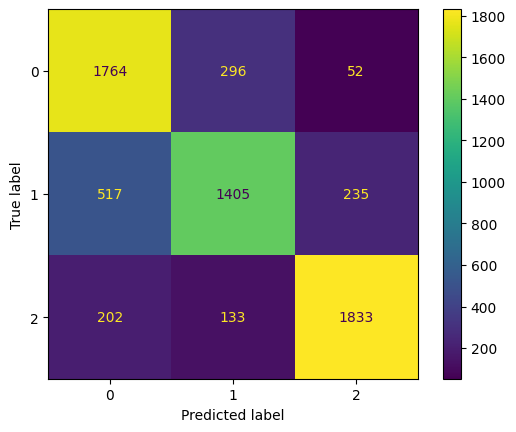

In [10]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Salvar modelo

In [11]:
with open('lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm, f)